# Part 4: Covid-19 transmission in Switzerland

In [141]:
# To load necessary packages
library(readr)
library(cmdstanr)
library(tidybayes)
library(data.table)
library(bayesplot)
library(ggplot2)
library(stringr)

In [142]:
# To load functions
source("sir_func.r")

## 1. SIR model

In [143]:
# To read & preview data
df_swiss <- read_csv("swiss_agg_data.csv") |> as.data.frame()

Rows: 132 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (8): onset_dt, test_dt, report_dt, hospit_dt, death_dt, death_dt_hospit...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


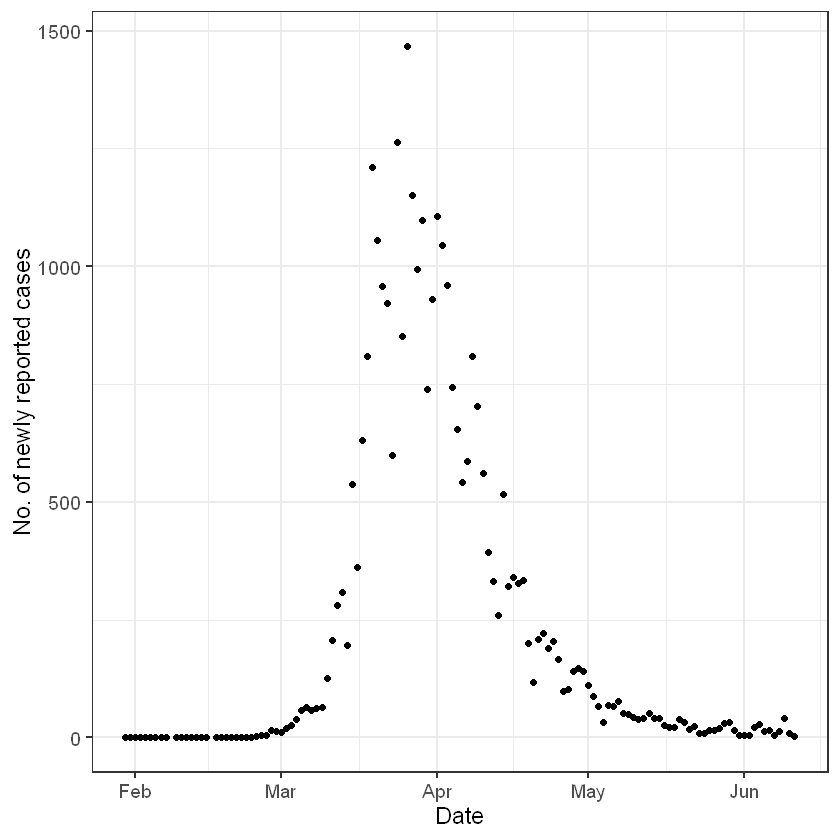

In [144]:
# To plot no. of reported cases over time
ggplot(data = df_swiss) +
geom_point(aes(x = date, y = report_dt)) +
labs(x = "Date", y = "No. of newly reported cases") +
theme_bw(base_size = 14)

In [145]:
# To define input data
N <- 8.57E6
cases <- df_swiss$report_dt
n_days <- length(cases)
t <- seq(from = 1, to = n_days, by = 1)
t0 <- 0

# To define initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 <- c(S = s0, I = i0, R = r0)

# To create a list of input data
sir_data <- list(n_days = n_days, y0 = y0, t0 = t0,
                 ts = t, N = N, cases = cases)

In [146]:
# To compile & fit Stan model
sir_v3_fit <- fit_model("sir_v3", sir_data)

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpueqOxB/model-8a9c49391406.stan', line 37, column 4 to column 74)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpueqOxB/model-8a9c49391406.stan', line 37, column 4 to column 74)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

In [147]:
# To define model parameters of interest
sir_parm <- c("beta", "gamma", "phi")

# To inspect summary of model fit
sir_v3_summ <- sir_v3_fit$summary(sir_parm)
print(sir_v3_summ)

# A tibble: 3 × 10
  variable  mean median     sd    mad     q5   q95  rhat ess_bulk ess_tail
  <chr>    <dbl>  <dbl>  <dbl>  <dbl>  <dbl> <dbl> <dbl>    <dbl>    <dbl>
1 beta     1.33   0.901 0.932  0.836  0.381  2.66   1.74     6.22     218.
2 gamma    1.05   0.585 1.03   0.830  0.0366 2.49   1.74     6.22     228.
3 phi      0.290  0.289 0.0281 0.0280 0.246  0.340  1.02   660.      1108.


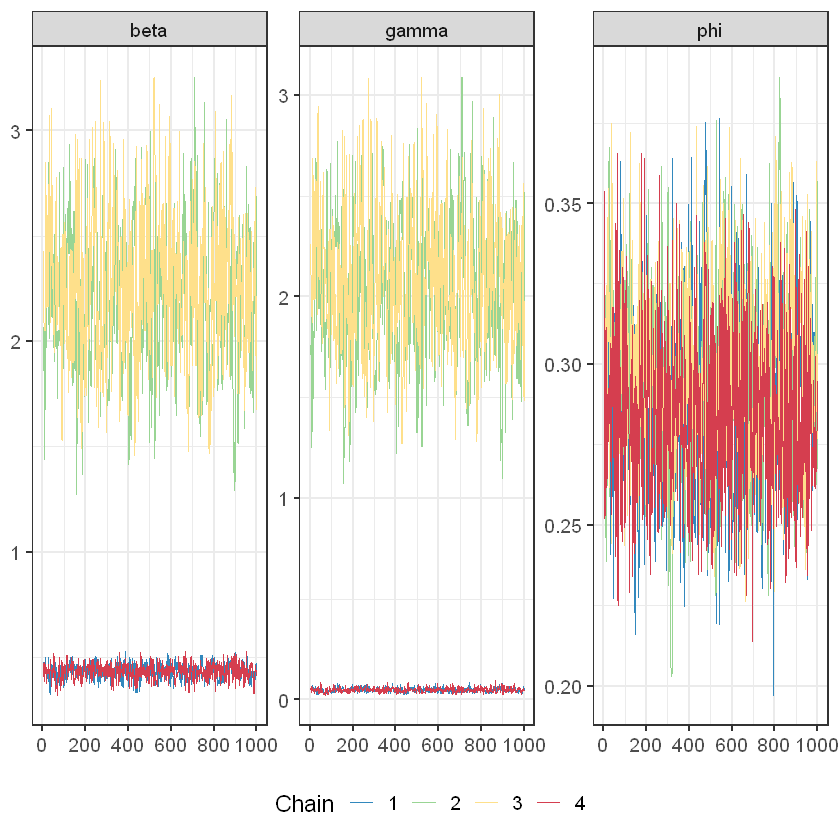

In [148]:
# To plot MCMC trace plots for marginal posteriors
plot_trace(sir_v3_fit, sir_parm)

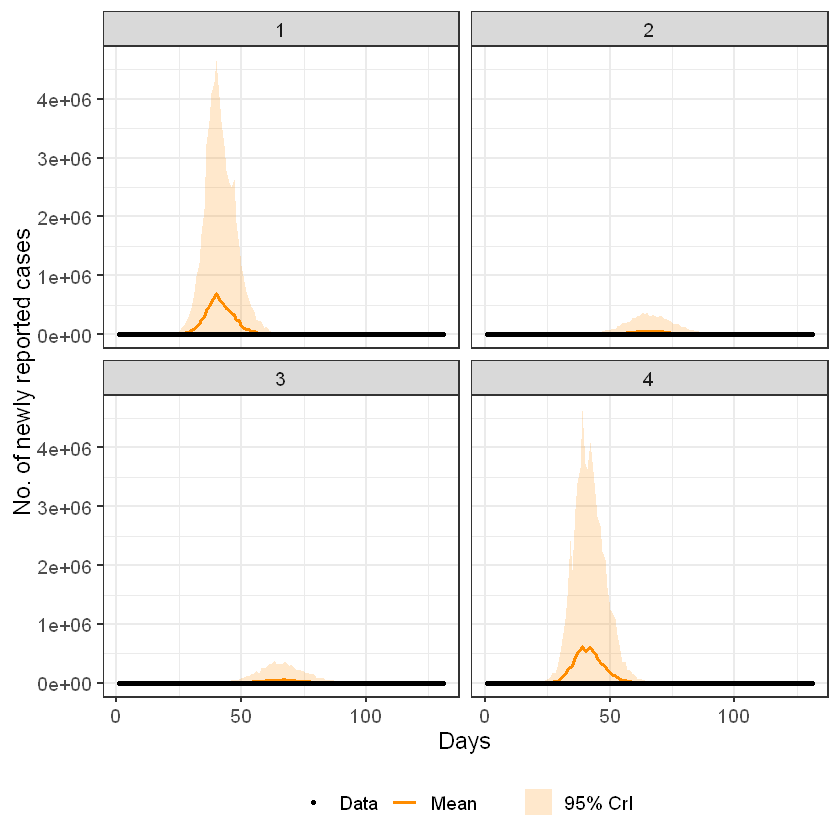

In [149]:
# To draw pred_cases from posterior
sir_v3_pred <- data.table(
    spread_draws(sir_v3_fit, pred_cases[t])
) |> remove_dots()

# To summarize pred_cases by chain
sir_v3_pred_summ_4chains <- summ_pred_4chains(sir_v3_pred)

# To plot pred_cases by chain
plot_pred_4chains(sir_v3_pred_summ_4chains)

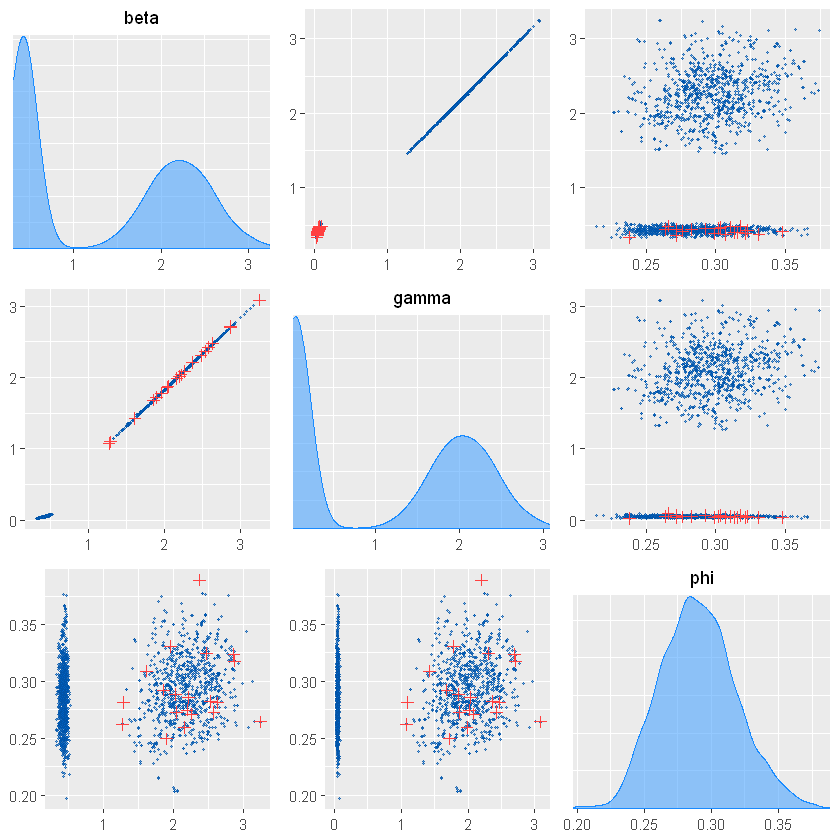

In [150]:
# To plot pair plots
plot_pairs(sir_v3_fit, sir_parm)

## 2. SIR model with underreporting

In [151]:
# To compile & fit Stan model
sir_v4_fit <- fit_model("sir_v4", sir_data)

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpINIiCm/model-95dc43804759.stan', line 38, column 4 to column 74)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ode_rk45: ode parameters and data is inf, but must be finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpINIiCm/model-95dc43804759.stan', line 38, column 4 to column 74)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matri

In [152]:
# To inspect summary of model fit
sir_v4_summ <- sir_v4_fit$summary(sir_parm)
print(sir_v4_summ)

# A tibble: 3 × 10
  variable   mean median      sd     mad     q5    q95  rhat ess_bulk ess_tail
  <chr>     <dbl>  <dbl>   <dbl>   <dbl>  <dbl>  <dbl> <dbl>    <dbl>    <dbl>
1 beta     0.327  0.326  0.00678 0.00643 0.316  0.338   1.00    1939.    1857.
2 gamma    0.0717 0.0715 0.00644 0.00607 0.0614 0.0827  1.00    1935.    1887.
3 phi      1.59   1.58   0.195   0.196   1.28   1.92    1.00    2782.    2440.


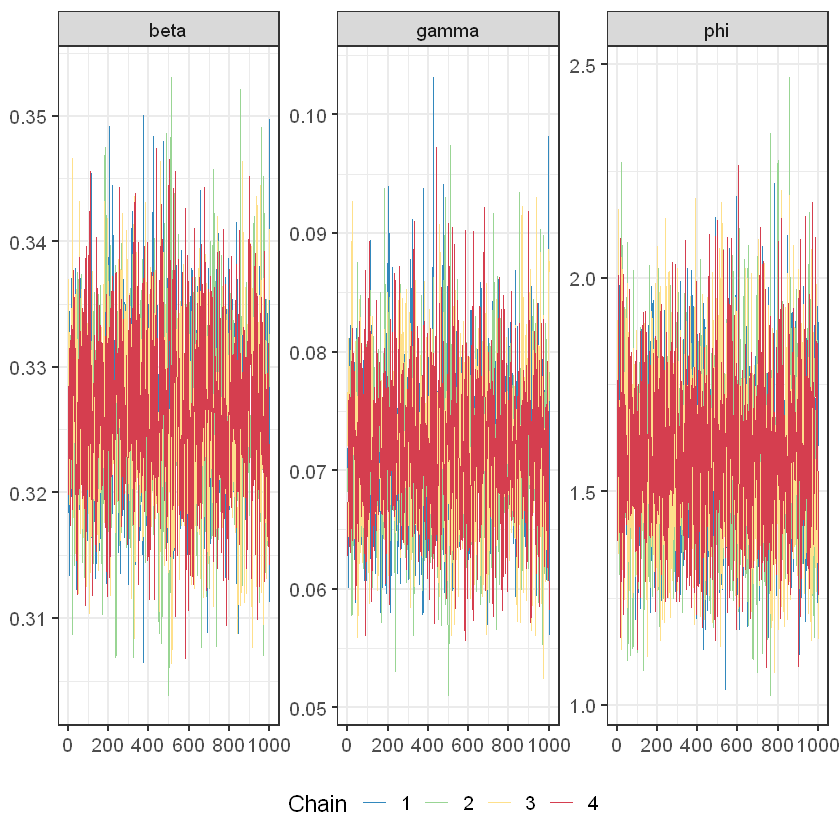

In [153]:
# To plot MCMC trace plots for marginal posteriors
plot_trace(sir_v4_fit, sir_parm)

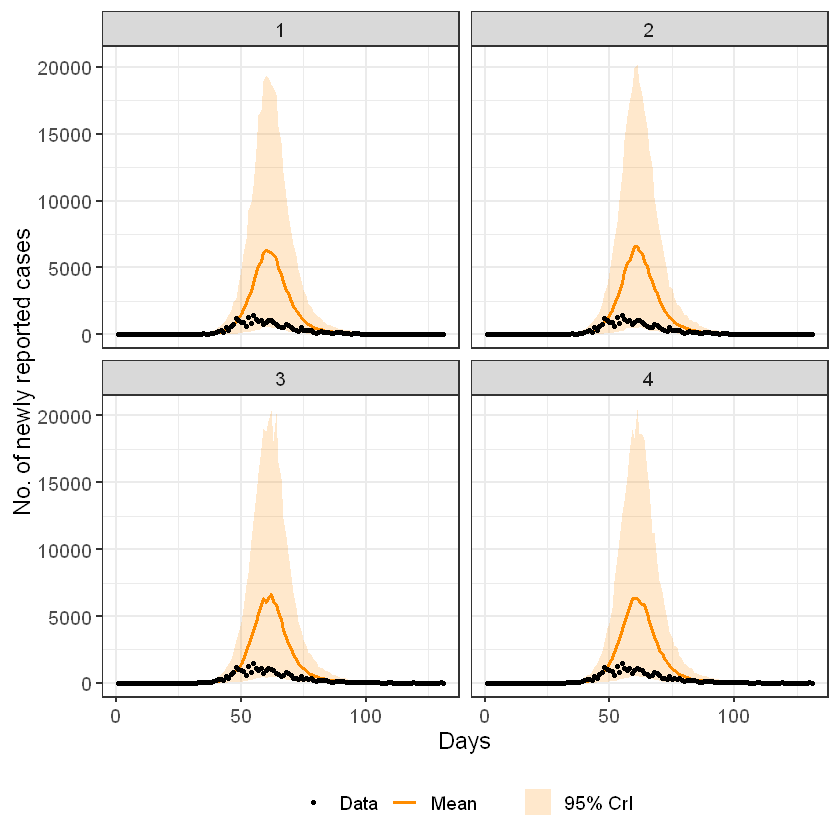

In [154]:
# To draw pred_cases from posterior
sir_v4_pred <- data.table(
    spread_draws(sir_v4_fit, pred_cases[t])) |> remove_dots()

# To summarize pred_cases by chain
sir_v4_pred_summ_4chains <- summ_pred_4chains(sir_v4_pred)

# To plot pred_cases by chain
plot_pred_4chains(sir_v4_pred_summ_4chains)

## 3. SEIR model with varying initial infections

In [155]:
# To re-define initial conditions
e0 <- 0
y0_seir <- c(y0, e0)

# To create a list of input data
seir_data <- modifyList(sir_data, list(y0 = y0_seir))

In [156]:
# To compile & fit Stan model
seir_v1_fit <- fit_model("seir_v1", seir_data)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[7] is -4.52361e-08, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpINIiCm/model-95dc75c8490c.stan', line 75, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[79] is -1.72559e-11, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpINIiCm/model-95dc75c8490c.stan', line 75, column 4 to column 59)

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[1] is 0, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpINIiCm/model-95dc75c8490c.stan', line 75, column 4 to column 59)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned

In [157]:
# To define model parameters of interest
seir_parm <- c(sir_parm, "delta")
seir_ini <- c("e0", "i0", "p_reported")

# To inspect summary of model fit
seir_v1_summ <- seir_v1_fit$summary(c(seir_parm, seir_ini))
print(seir_v1_summ)

# A tibble: 7 × 10
  variable      mean  median       sd      mad      q5     q95  rhat ess_bulk
  <chr>        <dbl>   <dbl>    <dbl>    <dbl>   <dbl>   <dbl> <dbl>    <dbl>
1 beta       2.09    2.06    0.949    0.964    0.557   3.67     1.00    2128.
2 gamma      0.587   0.537   0.373    0.391    0.0750  1.27     1.00    1972.
3 phi        7.20    7.10    1.27     1.21     5.27    9.49     1.00    3415.
4 delta      1.38    1.37    0.338    0.330    0.856   1.97     1.00    1826.
5 e0         0.406   0.405   0.00737  0.00706  0.395   0.419    1.00    1854.
6 i0         0.0675  0.0676  0.00237  0.00245  0.0636  0.0714   1.00    2530.
7 p_reported 0.00368 0.00367 0.000188 0.000183 0.00338 0.00399  1.00    2532.
# ℹ 1 more variable: ess_tail <dbl>


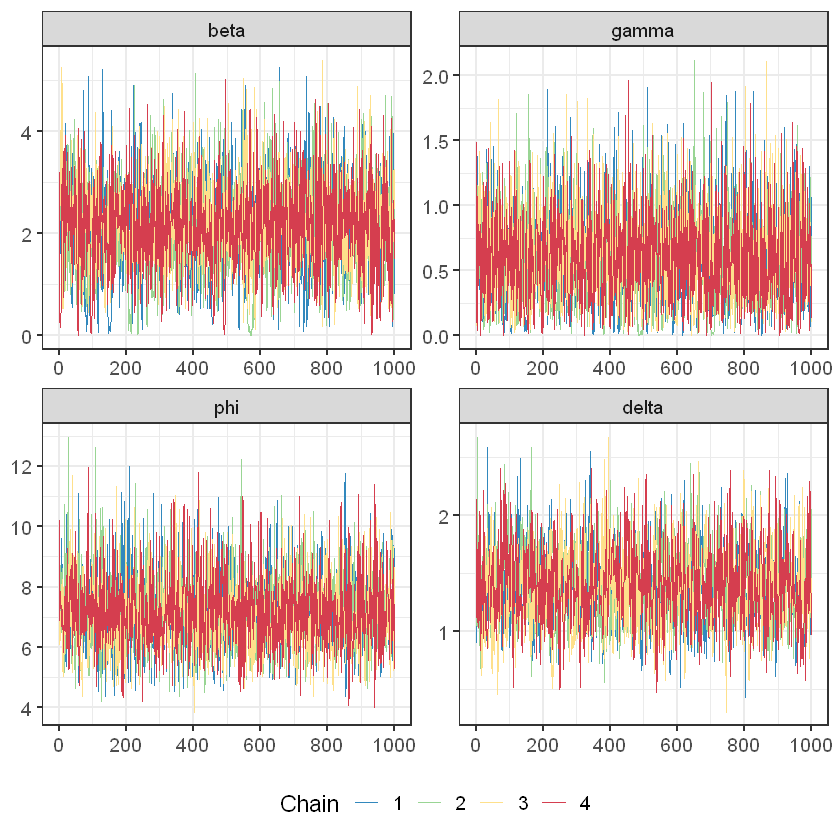

In [158]:
# To plot MCMC trace plots for marginal posteriors
plot_trace(seir_v1_fit, seir_parm)

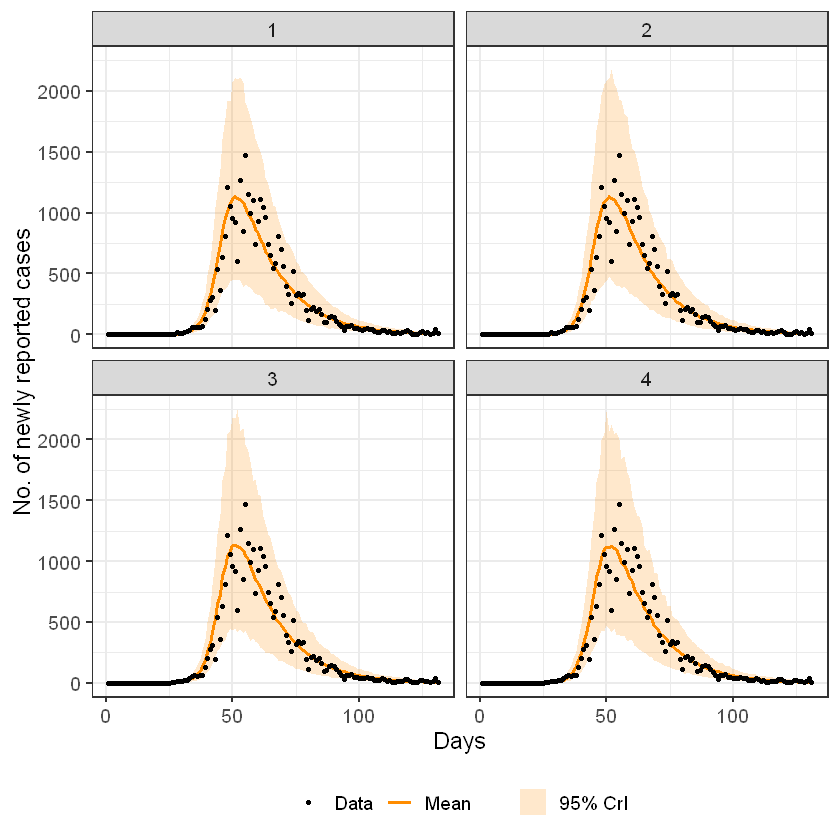

In [159]:
# To draw pred_cases from posterior
seir_v1_pred <- data.table(
    spread_draws(seir_v1_fit, pred_cases[t])) |> remove_dots()

# To summarize pred_cases by chain
seir_v1_pred_summ_4chains <- summ_pred_4chains(seir_v1_pred)

# To plot pred_cases by chain
plot_pred_4chains(seir_v1_pred_summ_4chains)

## 4. SEIR model with varying initial infections & control measures

Recall that the logistic function is given by $f(x) = \frac{L}{1+e^{-k(x-x_0)}}$, where </br>
> $L$ is the supremum of the values of the function </br>
> $k$ is the logistic growth rate </br>
> $x_0$ is the function's midpoint </br>

The decreasing transmission due to government control measures is given by: </br>
$\beta(t) = \beta*f(t)$, with </br>
$f(t) = \eta + (1-\eta)*\frac{1}{1+e^(\xi*(t-t_1-\nu))}$, where </br>
> $\eta$ is the decrease in transmission while control measures are fully in place </br>
> $\xi$ is the slope fo the decrease </br>
> $\nu$ is the delay (from introduction) until the measures are 50% effective

In other words,
- If $t \rightarrow -\infty:\ e^{-\infty} = 0,\ f(t) \rightarrow 1 \quad \Rightarrow \quad \beta(t) = 1*\beta$
- If $t = t-\nu:\ e^0 = 1,\ f(t) = \frac{1+\eta}{2} \quad \Rightarrow \quad \beta(t) = (\frac{1+\eta}{2})*\beta$
- If $t \rightarrow \infty:\ e^{\infty} = \infty,\ f(t) \rightarrow 0 \quad \Rightarrow \quad \beta(t) = \eta*\beta$

In [160]:
# To calculate start time of control measures
date_switch <- "2020-03-13"
t_switch <- calc_time(df_swiss, date_switch)

# To create a list of input data
seir_v2_data <- c(seir_data, list(t_switch = t_switch))

In [161]:
# To compile & fit Stan model
seir_v2_fit <- fit_model("seir_v2", seir_v2_data)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[31] is -1.05064e-07, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpINIiCm/model-95dc32fe21b4.stan', line 101, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[55] is -4.21889e-10, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpINIiCm/model-95dc32fe21b4.stan', line 101, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[55] is -2.04634e-10, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpINIiCm/model-95dc32fe21b4.stan', line 101, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[82] is -3.13459e-10, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/RtmpINIiCm/model-95dc32fe21b4.stan', line 101, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[39] is -2.92971e-10, but must be positive finite! (in 'C:/Users/J

In [162]:
# To define model parameters of interest
seir_v2_parm <- c(seir_parm, "eta", "nu", "xi")

# To inspect summary of model fit
seir_v2_summ <- seir_v2_fit$summary(c(seir_v2_parm, seir_ini))
print(seir_v2_summ)

# A tibble: 10 × 10
   variable      mean  median       sd      mad      q5      q95  rhat ess_bulk
   <chr>        <dbl>   <dbl>    <dbl>    <dbl>   <dbl>    <dbl> <dbl>    <dbl>
 1 beta       2.04    2.01    0.926    0.975    0.545    3.61     1.00    1660.
 2 gamma      0.590   0.552   0.368    0.392    0.0731   1.28     1.00    2189.
 3 phi        8.20    8.05    1.46     1.39     6.07    10.8      1.00    3661.
 4 delta      0.588   0.543   0.380    0.399    0.0600   1.29     1.00    2087.
 5 eta        0.386   0.373   0.178    0.194    0.121    0.702    1.00    5406.
 6 nu         5.86    5.43    2.54     2.28     2.55    10.4      1.00    2189.
 7 xi         0.997   0.997   0.288    0.374    0.550    1.44     1.00    4579.
 8 e0         0.370   0.369   0.0111   0.0109   0.352    0.389    1.00    2175.
 9 i0         0.0698  0.0698  0.00249  0.00248  0.0657   0.0739   1.00    3043.
10 p_reported 0.00351 0.00350 0.000172 0.000171 0.00323  0.00380  1.00    3270.
# ℹ 1 more variable:

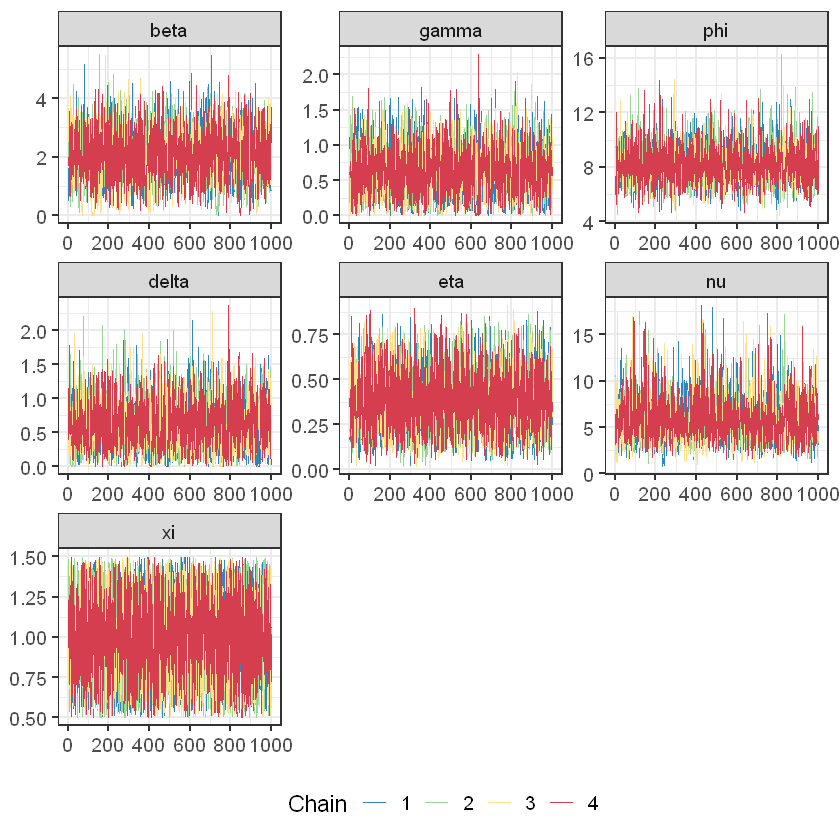

In [163]:
# To plot MCMC trace plots for marginal posteriors
plot_trace(seir_v2_fit, seir_v2_parm)

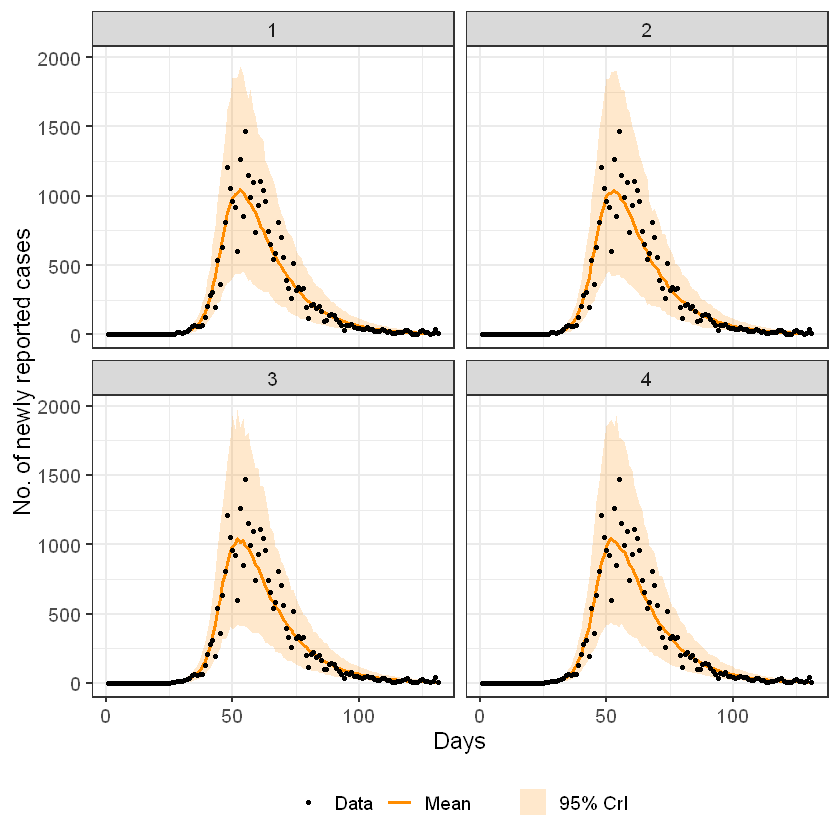

In [164]:
# To draw pred_cases from posterior
seir_v2_pred <- data.table(
    spread_draws(seir_v2_fit, pred_cases[t])) |> remove_dots()

# To summarize pred_cases by chain
seir_v2_pred_summ_4chains <- summ_pred_4chains(seir_v2_pred)

# To plot pred_cases by chain
plot_pred_4chains(seir_v2_pred_summ_4chains)

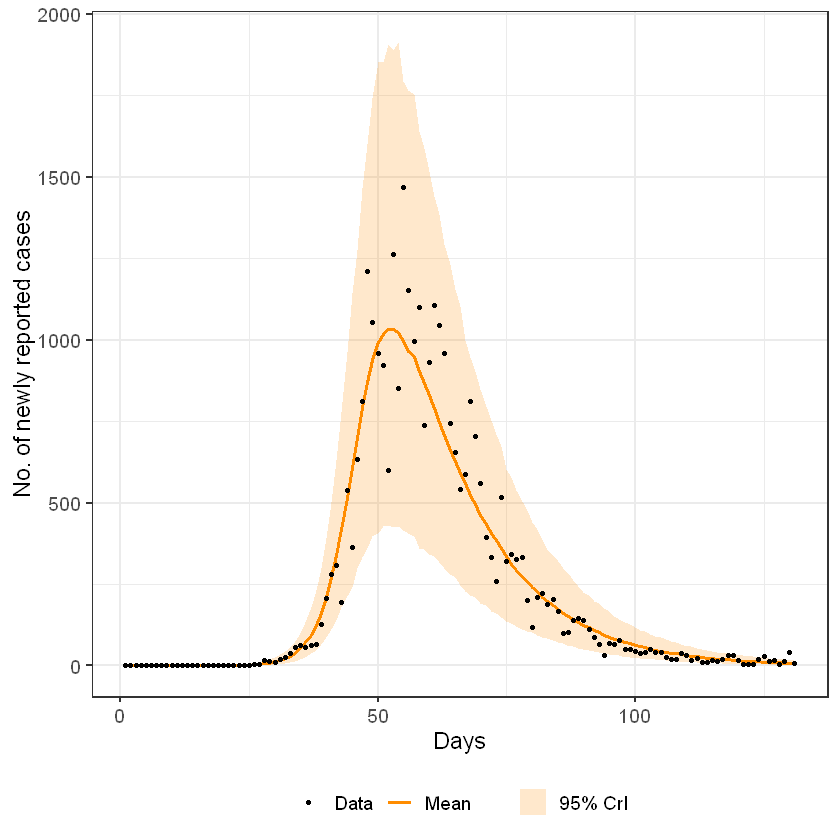

In [165]:
# To summarize pred_cases
seir_v2_pred_summ <- summ_pred(seir_v2_pred)

# To plot pred_cases
plot_pred(seir_v2_pred_summ)

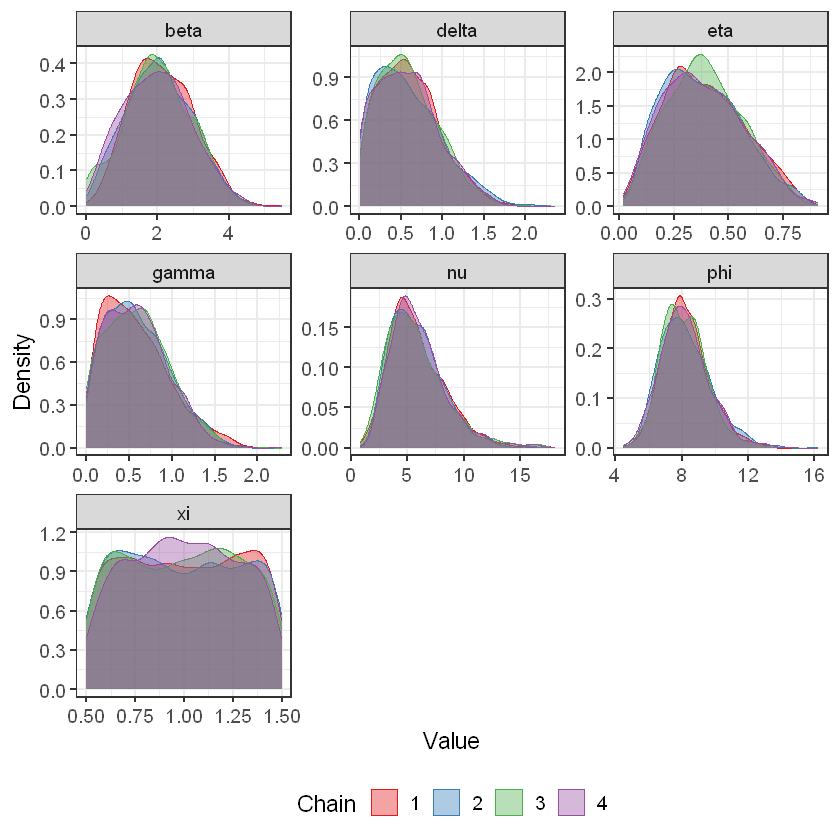

In [166]:
# To retrieve posterior samples
seir_v2_post <- data.table(
    gather_draws(seir_v2_fit, beta, gamma, phi, delta, eta, nu, xi)
) |> remove_dots()

# To preview datatable
plot_post(seir_v2_post)

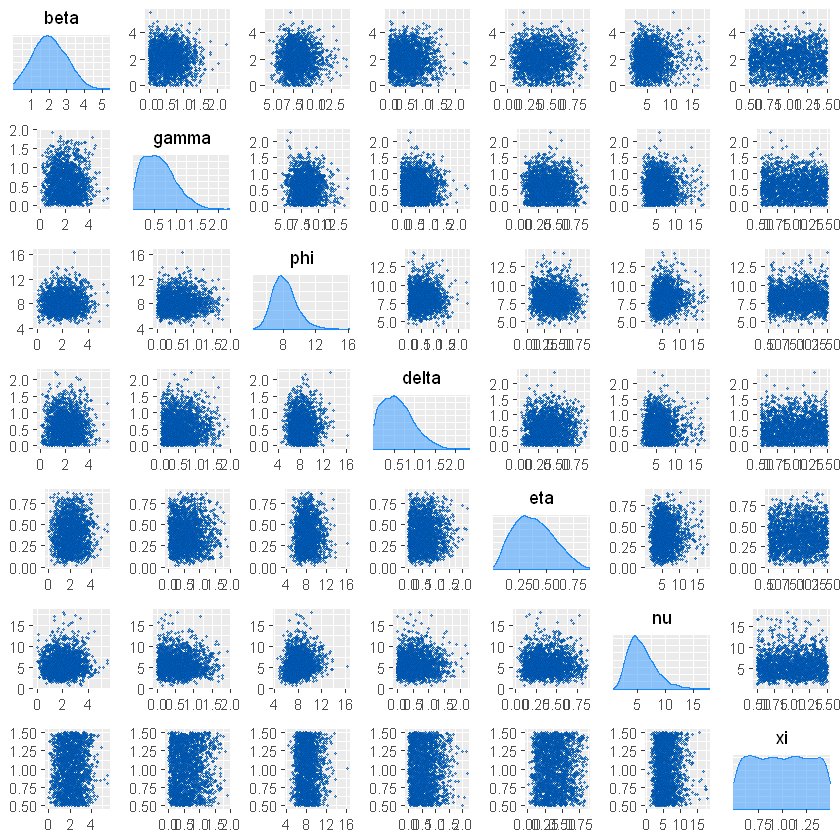

In [167]:
# To plot pair plots
plot_pairs(seir_v2_fit, seir_v2_parm)

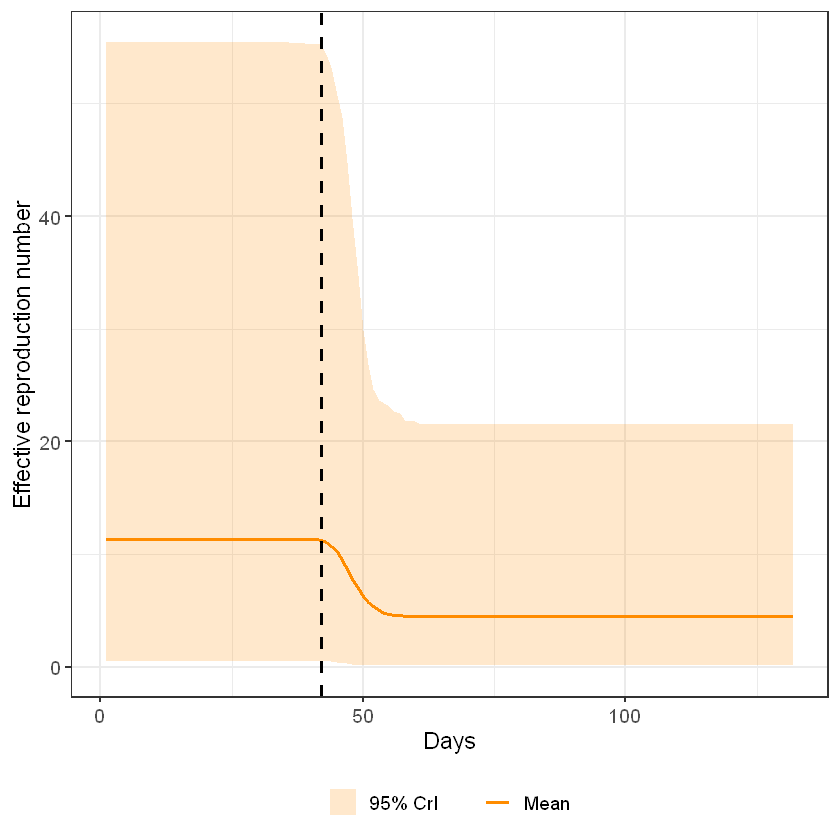

In [168]:
# To draw R0 from posterior
seir_v2_Reff <- data.table(
    spread_draws(seir_v2_fit, Reff[t])) |> remove_dots()

# To summarize Reff
seir_v2_Reff_summ <- summ_Reff(seir_v2_Reff)

# To plot Reff over time
plot_Reff(seir_v2_Reff_summ)

## 5. SEIR model with varying initial infection, control measures & serological survey

In [169]:
# To calculate survey time points
date_survey_start <- "2020-05-04"
date_survey_end <- "2020-05-07"
t_survey_start <- calc_time(df_swiss, date_survey_start)
t_survey_end <- calc_time(df_swiss, date_survey_end)
n_survey_inf <- 83
n_survey_test <- 775

# To create a list of input data
seir_v3_data <- c(seir_v2_data,
                  list(t_survey_start = t_survey_start,
                       t_survey_end = t_survey_end,
                       n_survey_inf = n_survey_inf,
                       n_survey_test = n_survey_test))

In [170]:
# To compile & fit Stan model
seir_v3_fit <- fit_model("seir_v3", seir_v3_data)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[31] is -1.05064e-07, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/Rtmpiq1B3o/model-a0d41a7a3203.stan', line 112, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[55] is -4.21889e-10, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/Rtmpiq1B3o/model-a0d41a7a3203.stan', line 112, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[55] is -2.04634e-10, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/Rtmpiq1B3o/model-a0d41a7a3203.stan', line 112, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[82] is -3.13459e-10, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/Rtmpiq1B3o/model-a0d41a7a3203.stan', line 112, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[39] is -2.92971e-10, but must be positive finite! (in 'C:/Users/J

In [171]:
print(seir_v3_fit$cmdstan_diagnose())

Checking sampler transitions treedepth.
545 of 1000 (54.50%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
3 of 1000 (0.30%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.01, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  beta, p

In [172]:
# To inspect summary of model fit
seir_v3_summ <- seir_v3_fit$summary(c(seir_v2_parm, seir_ini))
print(seir_v3_summ)

# A tibble: 10 × 10
   variable   mean median     sd     mad      q5     q95  rhat ess_bulk ess_tail
   <chr>     <dbl>  <dbl>  <dbl>   <dbl>   <dbl>   <dbl> <dbl>    <dbl>    <dbl>
 1 beta     1.52   1.55   1.19   1.48    0.00312  3.51    1.53     7.22     30.5
 2 gamma    0.587  0.536  0.375  0.397   0.0636   1.29    1.00  1389.      954. 
 3 phi      2.79   1.02   3.24   0.204   0.792    9.37    1.53     7.20     27.4
 4 delta    0.584  0.529  0.382  0.397   0.0695   1.30    1.00  1641.     1017. 
 5 eta      0.387  0.372  0.177  0.189   0.117    0.696   1.00  2510.     2022. 
 6 nu       8.39   7.72   3.99   3.71    3.30    15.8     1.12    23.0     221. 
 7 xi       1.000  1.01   0.288  0.367   0.548    1.44    1.00  2061.     1818. 
 8 e0       1.73   2.08   0.813  0.341   0.360    2.56    1.53     7.29     29.0
 9 i0       1.57   1.96   0.887  0.340   0.0680   2.44    1.53     7.30     29.5
10 p_repor… 0.0313 0.0369 0.0173 0.00987 0.00338  0.0526  1.53     7.21     30.7


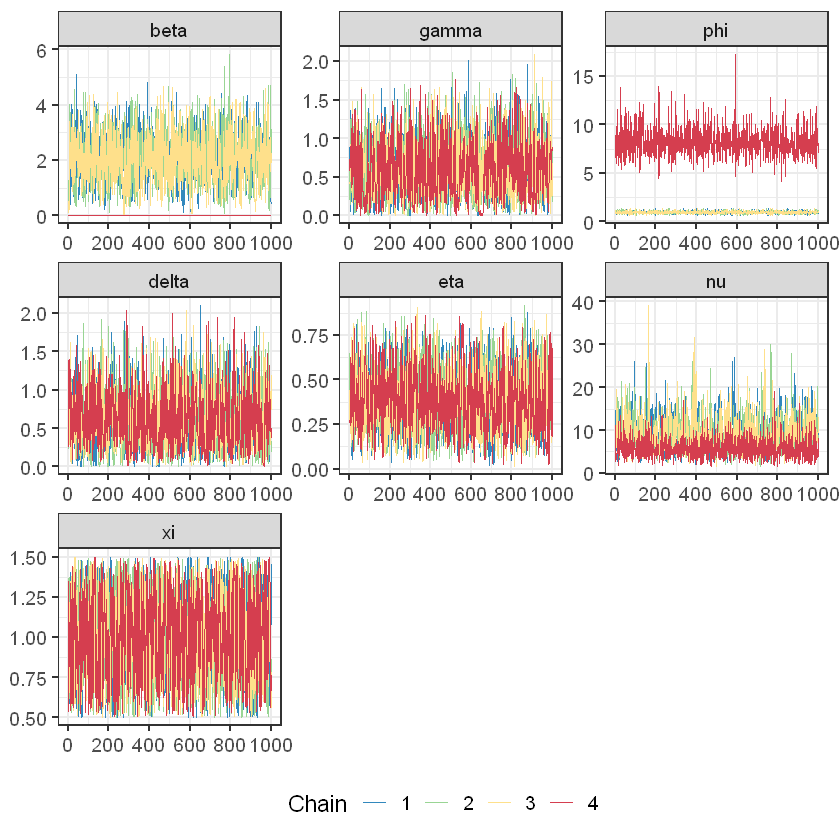

In [173]:
# To plot MCMC trace plots for marginal posteriors
plot_trace(seir_v3_fit, seir_v2_parm)

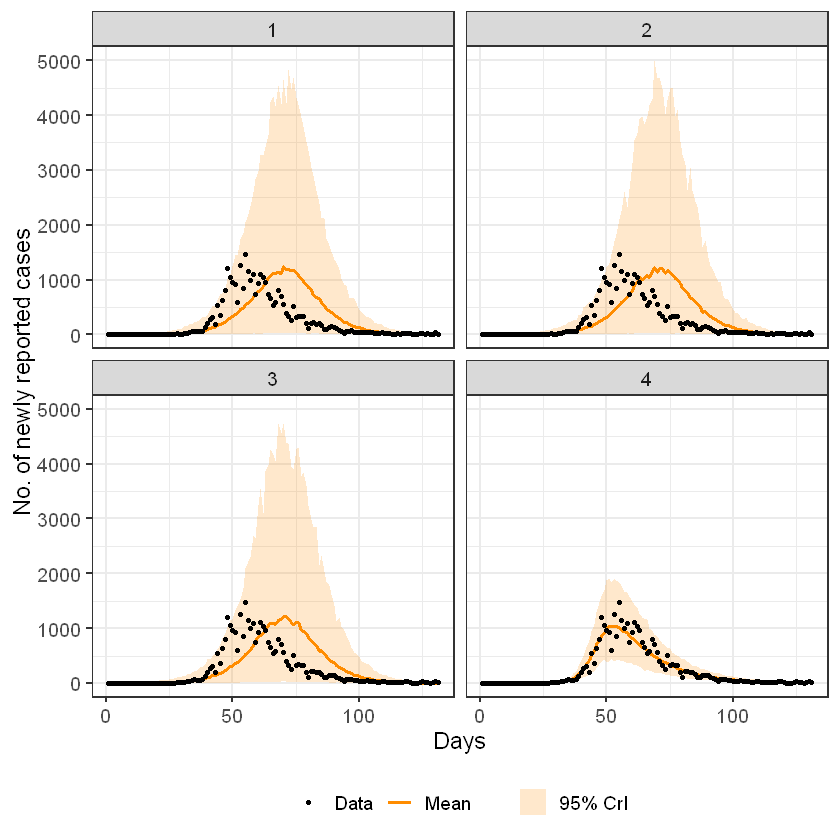

In [174]:
# To draw pred_cases from posterior
seir_v3_pred <- data.table(
    spread_draws(seir_v3_fit, pred_cases[t])) |> remove_dots()

# To summarize pred_cases by chain
seir_v3_pred_summ_4chains <- summ_pred_4chains(seir_v3_pred)

# To plot pred_cases by chain
plot_pred_4chains(seir_v3_pred_summ_4chains)

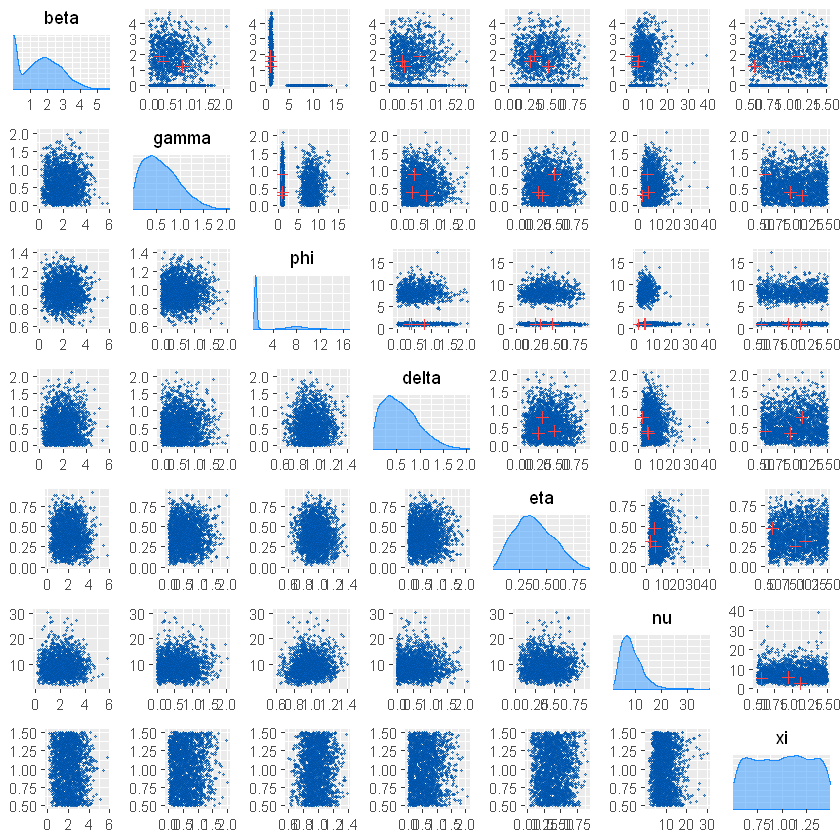

In [175]:
# To plot pair plots
plot_pairs(seir_v3_fit, seir_v2_parm)

In [176]:
# To compile & fit Stan model
seir_v3.1_fit <- fit_model("seir_v3",
                        seir_v3_data,
                        max_treedepth = 15,
                        adapt_delta = 0.9)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[31] is -1.05064e-07, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/Rtmpiq1B3o/model-a0d41a7a3203.stan', line 112, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[55] is -4.21889e-10, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/Rtmpiq1B3o/model-a0d41a7a3203.stan', line 112, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[55] is -2.04634e-10, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/Rtmpiq1B3o/model-a0d41a7a3203.stan', line 112, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[82] is -3.13459e-10, but must be positive finite! (in 'C:/Users/Jiheo/AppData/Local/Temp/Rtmpiq1B3o/model-a0d41a7a3203.stan', line 112, column 4 to column 59)

Chain 1 Exception: neg_binomial_2_lpmf: Location parameter[39] is -2.92971e-10, but must be positive finite! (in 'C:/Users/J

In [177]:
print(seir_v3.1_fit$cmdstan_diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.01, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  beta, phi_inv, nu, e0, i0, p_reported, phi, y[1,1], y[2,1], y[3,1], y[4,1], y[5,1], y[6,1], y[7,1], y[8,1], y[9,1], y[10,1], y[11,1], y[12,1], y[13,1], y[14,1], y[15,1], y[16,1], y[18,1], y[19,1], y[20,1], y[21,1], y[22,1], y[23,1], y[24,1], y[25,1], y[26,1], y[27,1], y[28,1], y[29,1], y[30,1], y[31,1], y[32,1], y[33,1], y[34,1], y[35,1], y[36,1], y[37,1], y[38,1], y[39,1], y[40,1], y[41,1], y[42,1], y[43,1], y[44,1], y[45,1], y[46,1], 

In [178]:
# To inspect summary of model fit
seir_v3.1_summ <- seir_v3.1_fit$summary(c(seir_v2_parm, seir_ini))
print(seir_v3.1_summ)

# A tibble: 10 × 10
   variable    mean median     sd    mad      q5     q95  rhat ess_bulk ess_tail
   <chr>      <dbl>  <dbl>  <dbl>  <dbl>   <dbl>   <dbl> <dbl>    <dbl>    <dbl>
 1 beta      1.51   1.58   1.20   1.55   0.00311  3.46    1.53     7.24     29.4
 2 gamma     0.573  0.520  0.383  0.397  0.0582   1.31    1.00  1689.      724. 
 3 phi       2.79   1.01   3.25   0.196  0.790    9.38    1.53     7.18     31.5
 4 delta     0.583  0.527  0.379  0.394  0.0605   1.28    1.00  1436.     1013. 
 5 eta       0.386  0.375  0.176  0.195  0.119    0.691   1.00  3952.     2594. 
 6 nu        8.65   7.88   4.04   3.51   3.57    16.2     1.13    22.2      88.3
 7 xi        0.997  0.997  0.285  0.368  0.555    1.44    1.00  3781.     2215. 
 8 e0        1.72   2.06   0.809  0.351  0.360    2.54    1.53     7.21     29.7
 9 i0        1.55   1.94   0.882  0.350  0.0680   2.41    1.53     7.20     31.5
10 p_report… 0.0307 0.0365 0.0168 0.0101 0.00337  0.0504  1.53     7.22     31.5


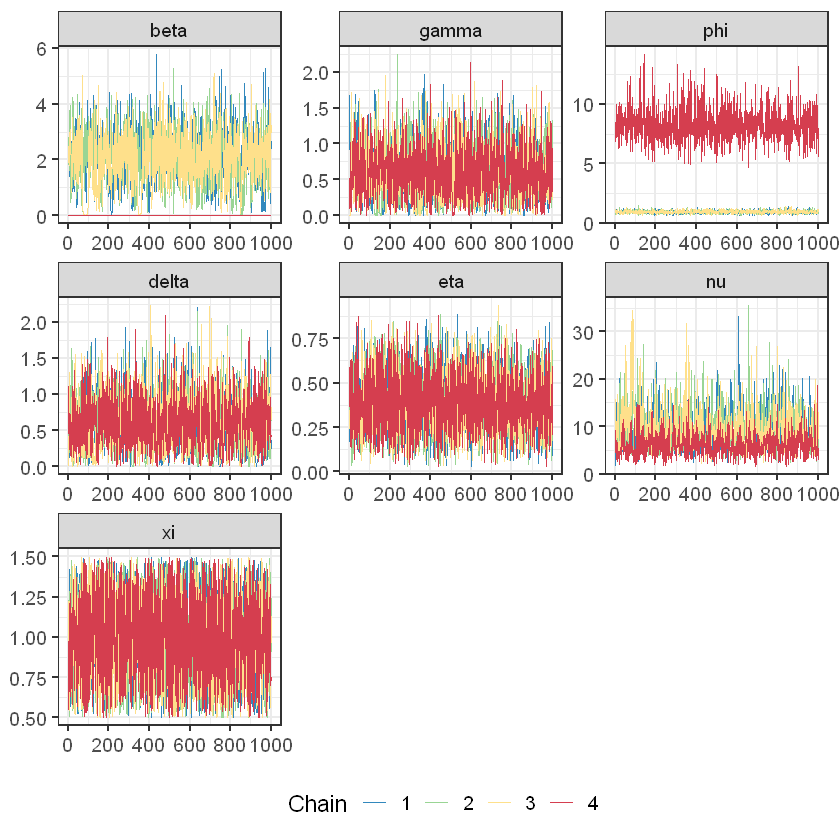

In [179]:
# To plot MCMC trace plots for marginal posteriors
plot_trace(seir_v3.1_fit, seir_v2_parm)

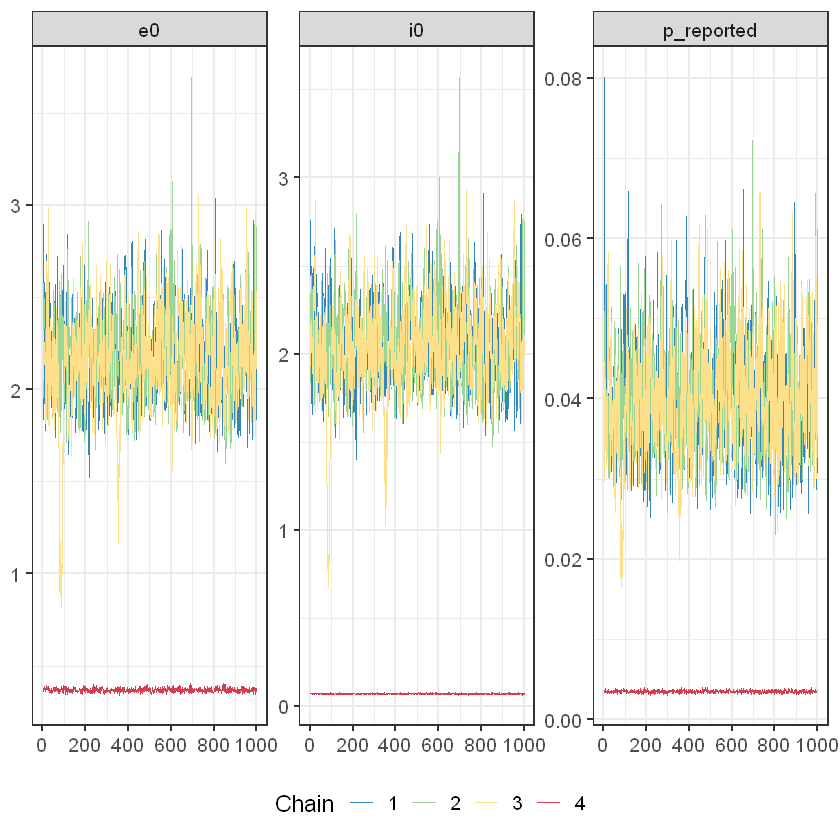

In [180]:
# To plot MCMC trace plots for marginal posteriors
plot_trace(seir_v3.1_fit, seir_ini)

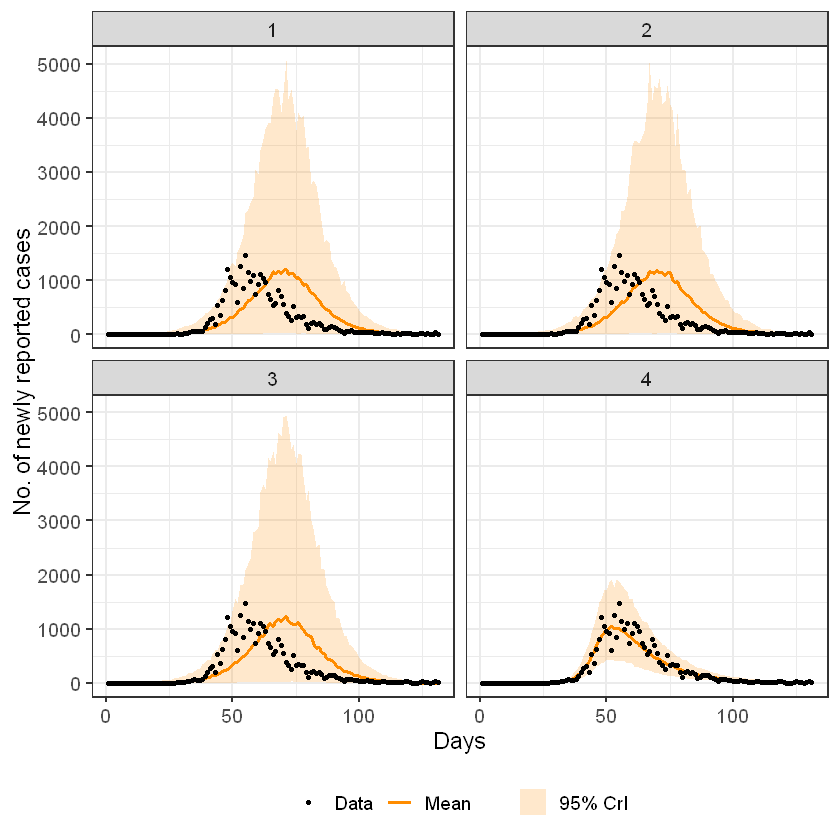

In [181]:
# To draw pred_cases from posterior
seir_v3.1_pred <- data.table(
    spread_draws(seir_v3.1_fit, pred_cases[t])) |> remove_dots()

# To summarize pred_cases by chain
seir_v3.1_pred_summ_4chains <- summ_pred_4chains(seir_v3.1_pred)

# To plot pred_cases by chain
plot_pred_4chains(seir_v3.1_pred_summ_4chains)

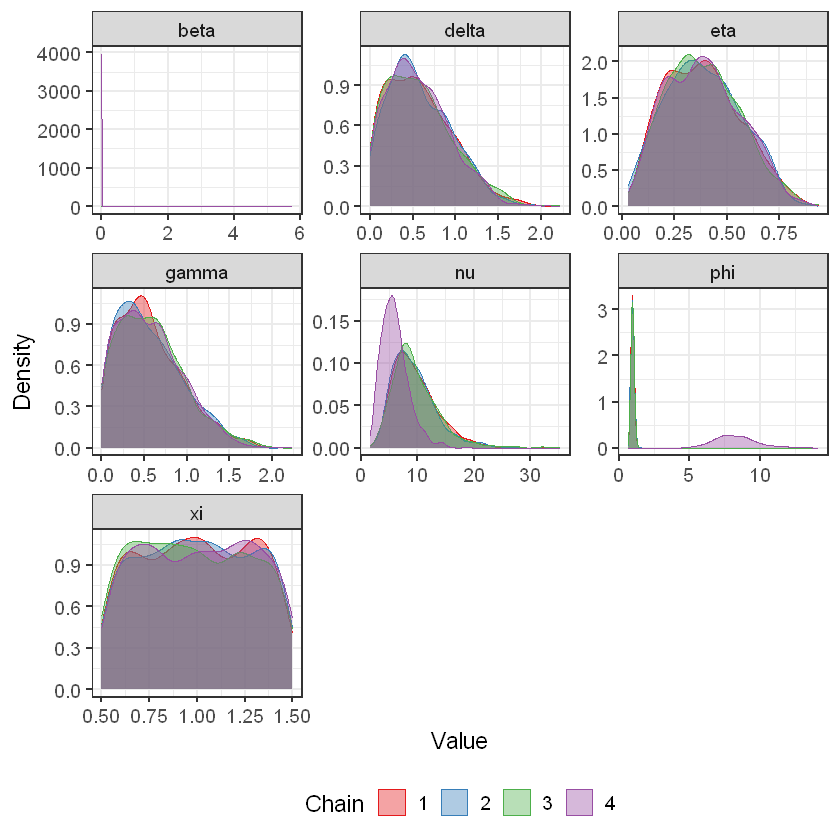

In [182]:
# To retrieve posterior samples
seir_v3.1_post <- data.table(
    gather_draws(seir_v3.1_fit, beta, gamma, phi, delta, eta, nu, xi)
) |> remove_dots()

# To preview datatable
plot_post(seir_v3.1_post)

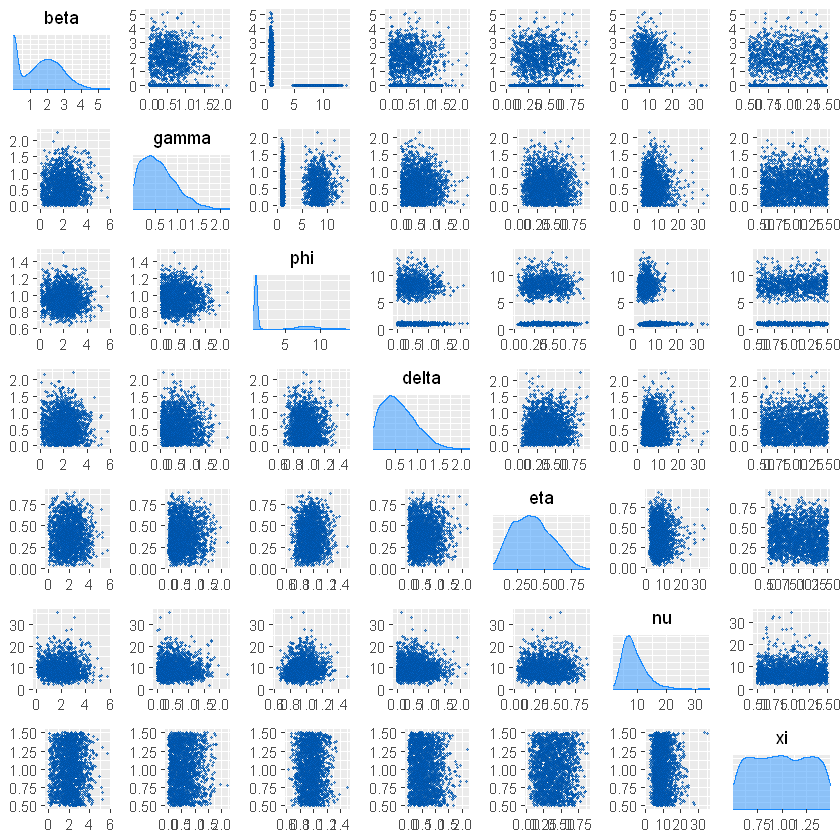

In [183]:
# To plot pair plots
plot_pairs(seir_v3.1_fit, seir_v2_parm)

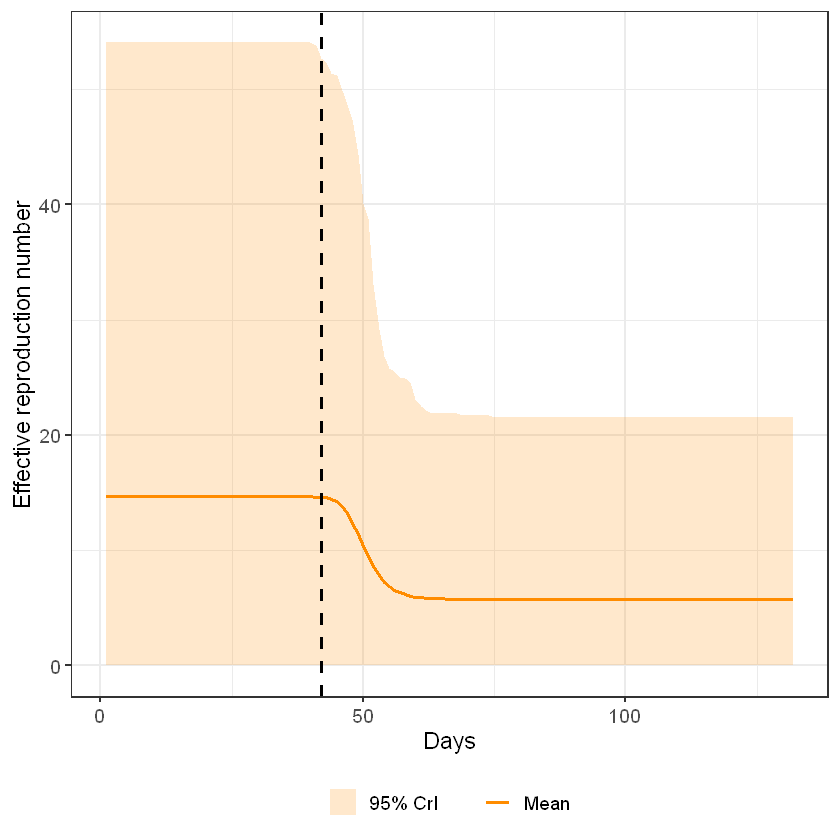

In [184]:
# To draw R0 from posterior
seir_v3.1_Reff <- data.table(
    spread_draws(seir_v3.1_fit, Reff[t]))

# To summarize Reff
seir_v3.1_Reff_summ <- summ_Reff(seir_v3.1_Reff)

# To plot Reff over time
plot_Reff(seir_v3.1_Reff_summ)